In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

pd.options.mode.chained_assignment = None  # default='warn' exclude warning for chained assingments

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) ## change float at the macro level

In [3]:
def BlackScholes (rf, spot, strike, T, sigma, div_yield):
    
    """""""""
    rf - risk free rate;
    spot - current spot price of the target asset;
    strike - option strike price;
    T - time, measured in years. For instance 1 month would be 1/12;
    sigma - expected annual volatility. For instance, 100% annual volatility would mean sigma in our model equals 1.
    
    c = S0*exp(-kT)*N(d1) - K*exp(-rfT)*N(d2)
    p = K*exp(-rfT)*N(-d2) - S0*exp(-kT)*N(-d1)

    """""""""
    
    d1 = (np.log(spot/strike) + T * (rf + (sigma**2)/2)) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    neg_d1 = -d1
    neg_d2 = -d2
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    N_neg_d1 = norm.cdf(neg_d1)
    N_neg_d2 = norm.cdf(neg_d2)
    
    exp1 = np.exp(-rf*T)
    exp2 = np.exp(-div_yield*T)
    
    
    call_price = spot  * exp2 * N_d1 - strike * exp1 * N_d2
    put_price = strike * exp1 * N_neg_d2 - spot * exp2 * N_neg_d1
    
    data = pd.DataFrame(data = [call_price, put_price], columns = ['Price'], index = ['Call', 'Put'])

    return data

In [4]:
def European_Binomial (rf, spot, strike, T, sigma, N, div_yield):
    
    """""""""
    rf - risk free rate;
    spot - current spot price of the target asset;
    strike - option strike price;
    T - time, measured in years. For instance 1 month would be 1/12;
    sigma - expected annual volatility. For instance, 100% annual volatility would mean sigma in our model equals 1.
    N - number of binomial steps;
    
    The factor by which the price raises: u = exp (std * sqrt(delta t));
    The factor by which the price falls: d = 1/u;
    Probability of price going up: pu = [exp(delta t * (rf - k)) - d] / [u - d];
    Probability of pirce going down: pd = 1 - pu;

    Stock price at the end of the period according to binomial model is:
    S0 * u ^ (# of steps up) * d ^ (# of steps down)
    """""""""
    
    delta_T = T/N
    
    NR = np.exp((rf - div_yield) * delta_T)
    GR = np.exp(rf*delta_T)
    
    u = np.exp(sigma * np.sqrt(delta_T))
    d = 1/u

    p_up = (NR - d) / (u - d) 
    p_down = 1 - p_up

    discount = np.exp(-rf*T)    
    
    df = pd.DataFrame(data = np.arange(0, N+1), columns = ["Number of down steps"])
    df['S(t)'] = spot * u ** (N - df['Number of down steps']) * d ** (df["Number of down steps"])

    call_price = []
    put_price = []
    for i in range(len(df)):
        call_price.append(max(0, float(df['S(t)'].iloc[i:i+1] - strike)))
        put_price.append(max(0, float(strike - df['S(t)'].iloc[i:i+1])))

    df["Call (t)"] = call_price
    df['Put (t)'] =  put_price

    df["Probability for the nod"] = p_up ** (N - df["Number of down steps"]) * p_down ** (df["Number of down steps"])

    df["Number"] = N

    df["Number Chosen"] = df["Number"] - df["Number of down steps"]

    paths = []
    for i in range(len(df)):
        paths.append ((np.math.factorial(float(df["Number"].iloc[i:i+1]))) / (np.math.factorial(float(df["Number Chosen"].iloc[i:i+1])) * np.math.factorial(float(df["Number"].iloc[i:i+1]) - float(df["Number Chosen"].iloc[i:i+1]))))

    df["Number of paths"] = paths

    df['Pr of S{t}'] = df["Probability for the nod"] * df["Number of paths"]

    df["Call (t) * Pr"] = df["Call (t)"] * df["Pr of S{t}"]
    df["Put (t) * Pr"] = df["Put (t)"] * df["Pr of S{t}"]
    
    data = pd.DataFrame(data = [df["Call (t) * Pr"].sum() * discount, df["Put (t) * Pr"].sum() * discount], columns = ['Price'], index = ['Call', 'Put'])
    
    return data, df

In [5]:
rf, spot, strike, T, sigma, N, div_yield = 0.06, 10, 8, 15/252, 0.4, 10, 0.02

input_frame = pd.DataFrame(data = [rf, spot, strike, T, sigma, N, div_yield], columns=['Input'], 
                   index=['Risk-free rate', 'Spot', 'Strike', 'T', 'Volatility', 'Number of steps', 'Dividend Yield'])
display(input_frame)

,Input
Risk-free rate,0.0600
Spot,10.0000
Strike,8.0000
T,0.0595
Volatility,0.4000
Number of steps,10.0000
Dividend Yield,0.0200


In [6]:
European_Binomial(rf, spot, strike, T, sigma, N, div_yield)[0]

,Price
Call,2.0193
Put,0.0026


In [7]:
BlackScholes (rf, spot, strike, T, sigma, div_yield)

,Price
Call,2.0197
Put,0.0031


In [8]:
def American_Option (rf, spot, strike, T, sigma, N, div_yield):
    
    """""""""
    rf - risk free rate;
    spot - current spot price of the target asset;
    strike - option strike price;
    T - time, measured in years. For instance 1 month would be 1/12;
    sigma - expected annual volatility. For instance, 100% annual volatility would mean sigma in our model equals 1.
    N - number of binomial steps;
    
    The factor by which the price raises: u = exp (std * sqrt(delta t));
    The factor by which the price falls: d = 1/u;
    Probability of price going up: pu = [exp(delta t * (rf - k)) - d] / [u - d];
    Probability of pirce going down: pd = 1 - pu;

    Stock price at the end of the period according to binomial model is:
    S0 * u ^ (# of steps up) * d ^ (# of steps down)
    """""""""
    
    delta_T = T/N

    NR = np.exp((rf - div_yield) * delta_T)
    GR = np.exp(rf*delta_T)

    u = np.exp(sigma * np.sqrt(delta_T))
    d = 1/u

    p_up = (NR - d) / (u - d) 
    p_down = 1 - p_up  


    tree = pd.DataFrame(np.zeros((N+1, N+1)))
    tree.iloc[0, 0] = spot

    for i in range (1, N+1):
        tree.iloc[0:1][i] = tree.iloc[0:1][i-1] * u #step up

    for z in range(1, N+1):

        tree.iloc[z:z+1][z] = float(tree.iloc[z-1:z][z-1] * d)

        for i in range(z+1, N+1):
            tree.iloc[z:z+1][i] = tree.iloc[z:z+1][i-1] * u

    call_payoff = tree.copy()
    call_payoff.iloc[:, N][call_payoff.iloc[:, N] - strike < 0] = 0
    call_payoff.iloc[:, N][call_payoff.iloc[:, N] - strike > 0] -= strike

    put_payoff = tree.copy()
    put_payoff.iloc[:, N][strike - put_payoff.iloc[:, N] > 0] = strike - put_payoff.iloc[:, N][strike - put_payoff.iloc[:, N] > 0]
    put_payoff.iloc[:, N][strike - put_payoff.iloc[:, N] < 0] = 0

    for z in range(N):
        for i in range(N-z):
            num = N - z - 1
            call_payoff.iloc[:, num][i] = max(call_payoff.iloc[:, num][i] - strike, ((p_up * call_payoff.iloc[:, num+1][i] + p_down * call_payoff.iloc[:, num+1][i+1]) / np.exp(rf * delta_T)))
            put_payoff.iloc[:, num][i] = max(strike - put_payoff.iloc[:, num][i], ((p_up * put_payoff.iloc[:, num+1][i] + p_down * put_payoff.iloc[:, num+1][i+1]) / np.exp(rf * delta_T)))

    data = pd.DataFrame(data = [call_payoff.iloc[0, 0], put_payoff.iloc[0, 0]], columns = ['Price'], index = ['Call', 'Put'])
    
    return data

In [9]:
American_Option(rf, spot, strike, T, sigma, N, div_yield)

,Price
Call,2.0193
Put,0.0026


In [10]:
def Power_call(rf, spot, strike, T, sigma, N, div_yield, power):

    delta_T = T/N

    NR = np.exp((rf - div_yield) * delta_T)
    GR = np.exp(rf*delta_T)

    u = np.exp(sigma * np.sqrt(delta_T))
    d = 1/u

    p_up = (NR - d) / (u - d) 
    p_down = 1 - p_up  


    tree = pd.DataFrame(np.zeros((N+1, N+1)))
    tree.iloc[0, 0] = spot

    for i in range (1, N+1):
        tree.iloc[0:1][i] = tree.iloc[0:1][i-1] * u #step up

    for z in range(1, N+1):

        tree.iloc[z:z+1][z] = float(tree.iloc[z-1:z][z-1] * d)

        for i in range(z+1, N+1):
            tree.iloc[z:z+1][i] = tree.iloc[z:z+1][i-1] * u
            
    call_payoff = tree.copy()
    call_payoff.iloc[:, N][call_payoff.iloc[:, N] - strike < 0] = 0
    call_payoff.iloc[:, N][call_payoff.iloc[:, N] - strike > 0] -= strike

    call_payoff.iloc[:, N] = call_payoff.iloc[:, N] ** power
    
    for z in range(N):
        for i in range(N-z):
            num = N - z - 1
            call_payoff.iloc[:, num][i] = max(call_payoff.iloc[:, num][i] - strike, ((p_up * call_payoff.iloc[:, num+1][i] + p_down * call_payoff.iloc[:, num+1][i+1]) / np.exp(rf * delta_T)))
        
    return call_payoff.iloc[0, 0]

In [11]:
Power_call(rf, spot, strike, T, sigma, N, div_yield, power = 3)

14.345918104531002

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 5) ## change plot size at the macro level
mpl.rcParams['figure.dpi'] = 300 ## graph resolution

In [46]:
rf, spot, strike, T, sigma, N, div_yield, power = 0.02, 80, 100, 30/360, 0.4, 20, 0.05, 2

input_frame = pd.DataFrame(data = [rf, spot, strike, T, sigma, N, div_yield, power], columns=['Input'], 
                   index=['Risk-free rate', 'Spot', 'Strike', 'T', 'Volatility', 'Number of steps', 'Dividend Yield', 'Power'])
print("Example")
display(input_frame)
print("Based on the inputs above, power call price would be: $", round(Power_call(rf, spot, strike, T, sigma, N, div_yield, power = power), 2))

Example


,Input
Risk-free rate,0.0200
Spot,80.0000
Strike,100.0000
T,0.0833
Volatility,0.4000
Number of steps,20.0000
Dividend Yield,0.0500
Power,2.0000


Based on the inputs above, power call price would be: $ 0.72


# 1. Power Call Price Relative to The Volatility Estimate

In [56]:
sigmas = np.arange(0.05, 1, 0.05)

prices_ = []
american_prices = []
for i in range(len(sigmas)):
    prices_.append(Power_call(rf, spot, strike, T, sigmas[i], N, div_yield, power = power))
    
df1 = pd.DataFrame(data = [sigmas, prices_], index = ['Volatility', 'Power Call']).T
df1 = df1.set_index('Volatility')

# 2. Power Call Price With Maturity 

In [59]:
maturity = np.arange(1, 361, 10)/360

In [63]:
prices_ = []
for i in range(len(maturity)):
    prices_.append(Power_call(rf, spot, strike, maturity[i], sigma, N, div_yield, power = power))
    
df2 = pd.DataFrame(data = [maturity, prices_], index = ['Maturity', 'Power Call']).T
df2 = df2.set_index('Maturity')

## 3. Power Call Price Relative to The Power

In [65]:
power_ = np.arange(2, 5, 0.1)

In [66]:
prices_ = []
for i in range(len(power_)):
    prices_.append(Power_call(rf, spot, strike, T, sigma, N, div_yield, power = power_[i]))
    
df3 = pd.DataFrame(data = [power_, prices_], index = ['Power', 'Power Call Price']).T
df3 = df3.set_index('Power')

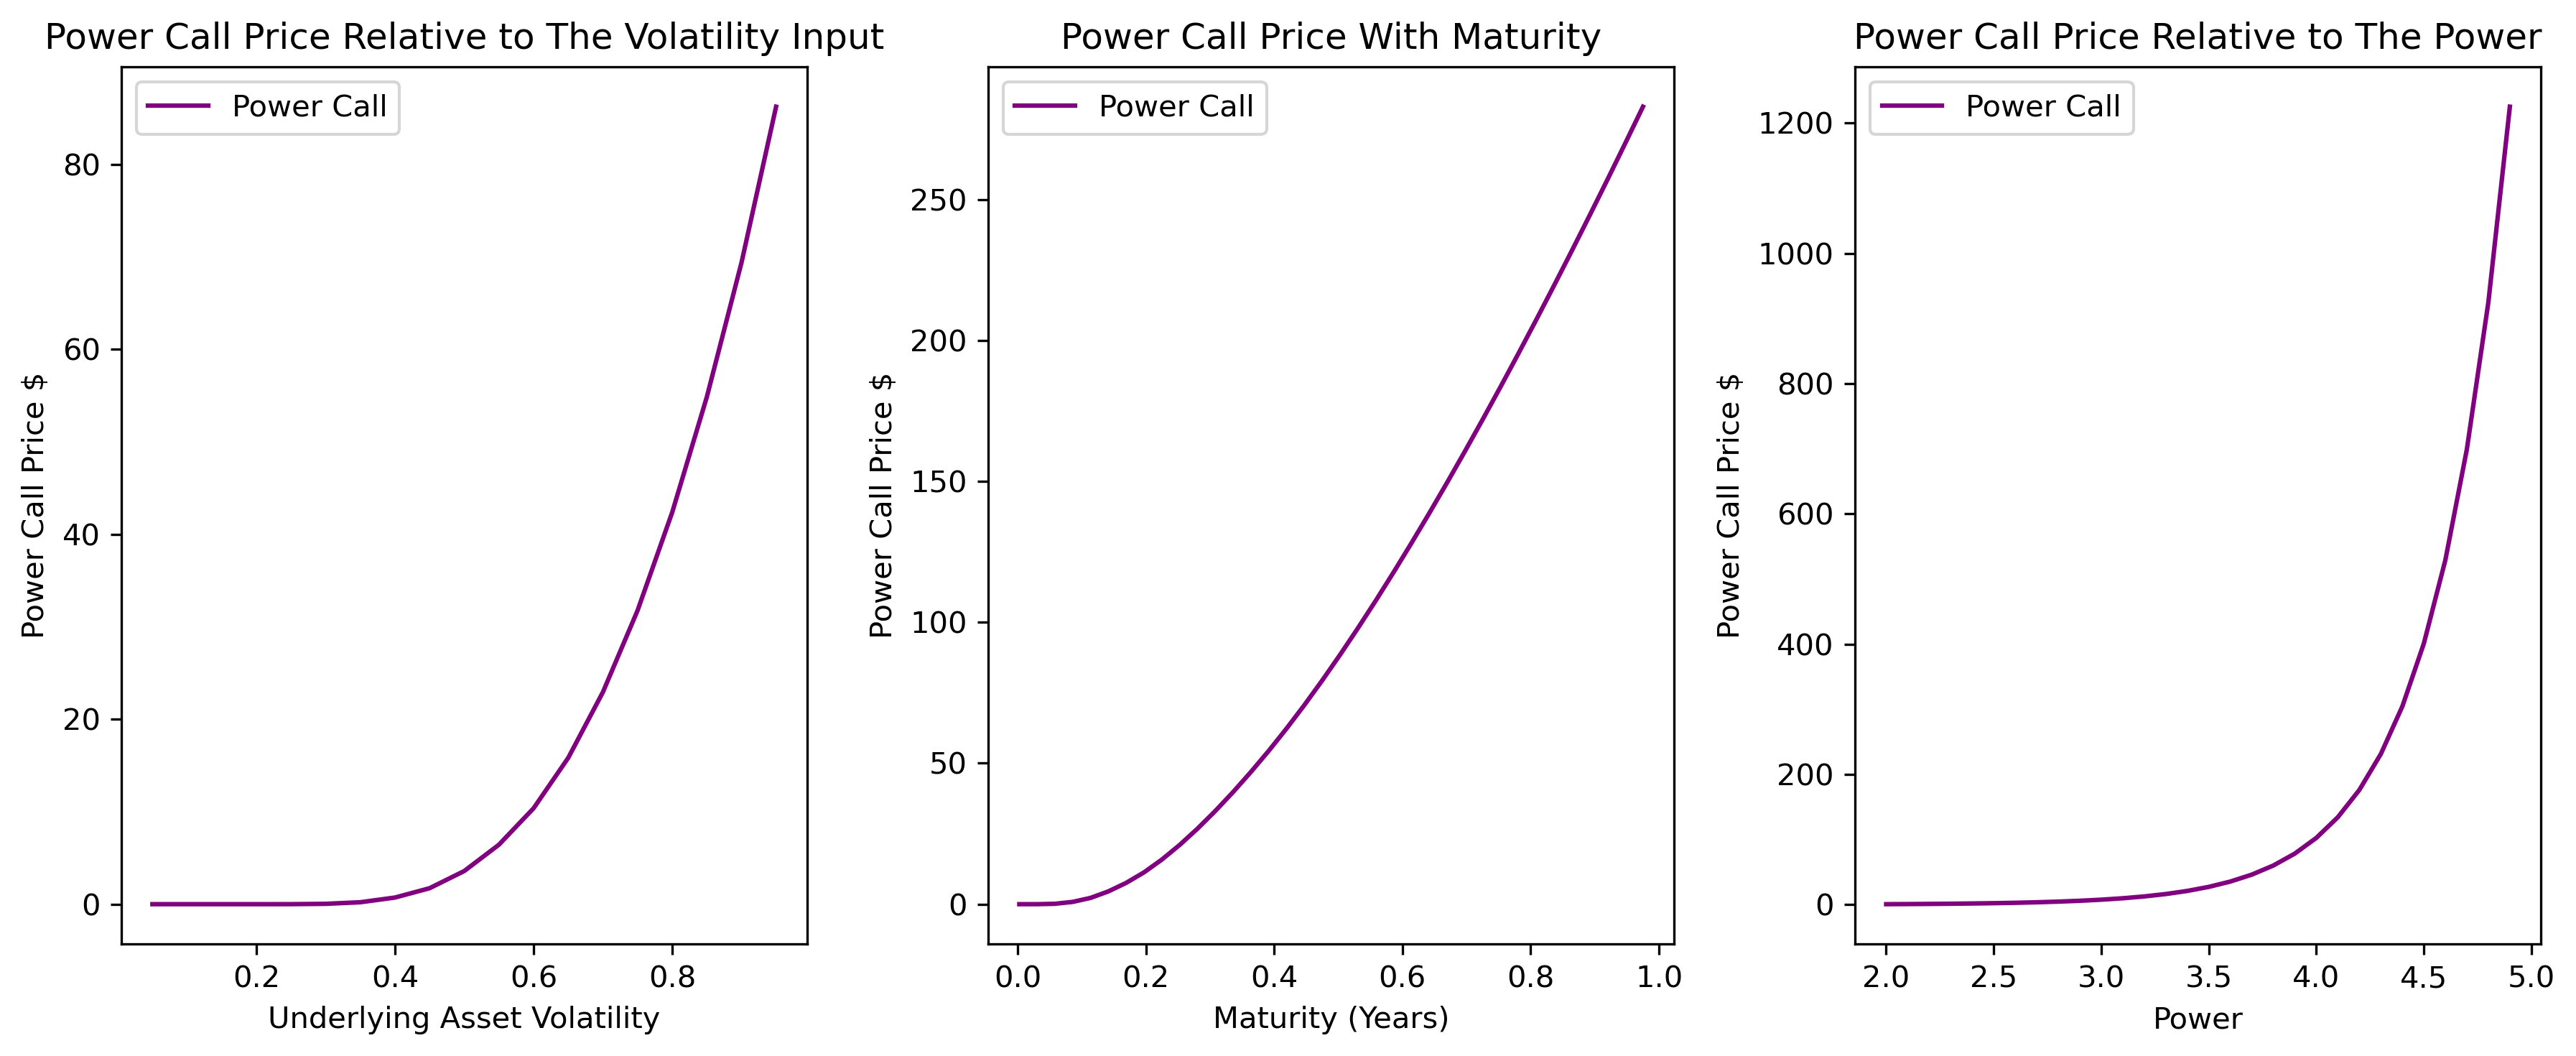

In [92]:
fig, ax = plt.subplots(1, 3)

ax[0].plot(df1, label = 'Power Call', color = 'purple')
ax[0].set_title('Power Call Price Relative to The Volatility Input')
ax[0].legend()
ax[0].set_xlabel("Underlying Asset Volatility")
ax[0].set_ylabel("Power Call Price $")

ax[1].plot(df2, label = 'Power Call', color = 'purple')
ax[1].set_title('Power Call Price With Maturity')
ax[1].legend()
ax[1].set_xlabel("Maturity (Years)")
ax[1].set_ylabel("Power Call Price $")

ax[2].plot(df3, label = 'Power Call', color = 'purple')
ax[2].set_title('Power Call Price Relative to The Power')
ax[2].legend()
ax[2].set_xlabel("Power")
ax[2].set_ylabel("Power Call Price $")

plt.tight_layout()

# 1a. Power Call Price Relative to The Spot Price

In [100]:
spot_ = np.arange(90, 120, 0.5)

prices_ = []
for i in range(len(spot_)):
    prices_.append(Power_call(rf, spot_[i], strike, T, sigma, N, div_yield, power = power))
    
df4 = pd.DataFrame(data = [spot_, prices_], index = ['Spot', 'Power Call']).T
df4 = df4.set_index('Spot')

payoff = spot_ - strike
payoff[payoff<0] = 0

df4['Payoff'] = (payoff**power)

# 2a. American Call vs Payoff

In [101]:
prices_ = []
for i in range(len(spot_)):
    prices_.append(American_Option(rf, spot_[i], strike, T, sigma, N, div_yield)['Price'][0])
    
df5 = pd.DataFrame(data = [spot_, prices_], index = ['Spot', 'American Call']).T
df5 = df5.set_index('Spot')

payoff = spot_ - strike
payoff[payoff<0] = 0

df5['Payoff'] = payoff

Text(0, 0.5, 'American Call Price $')

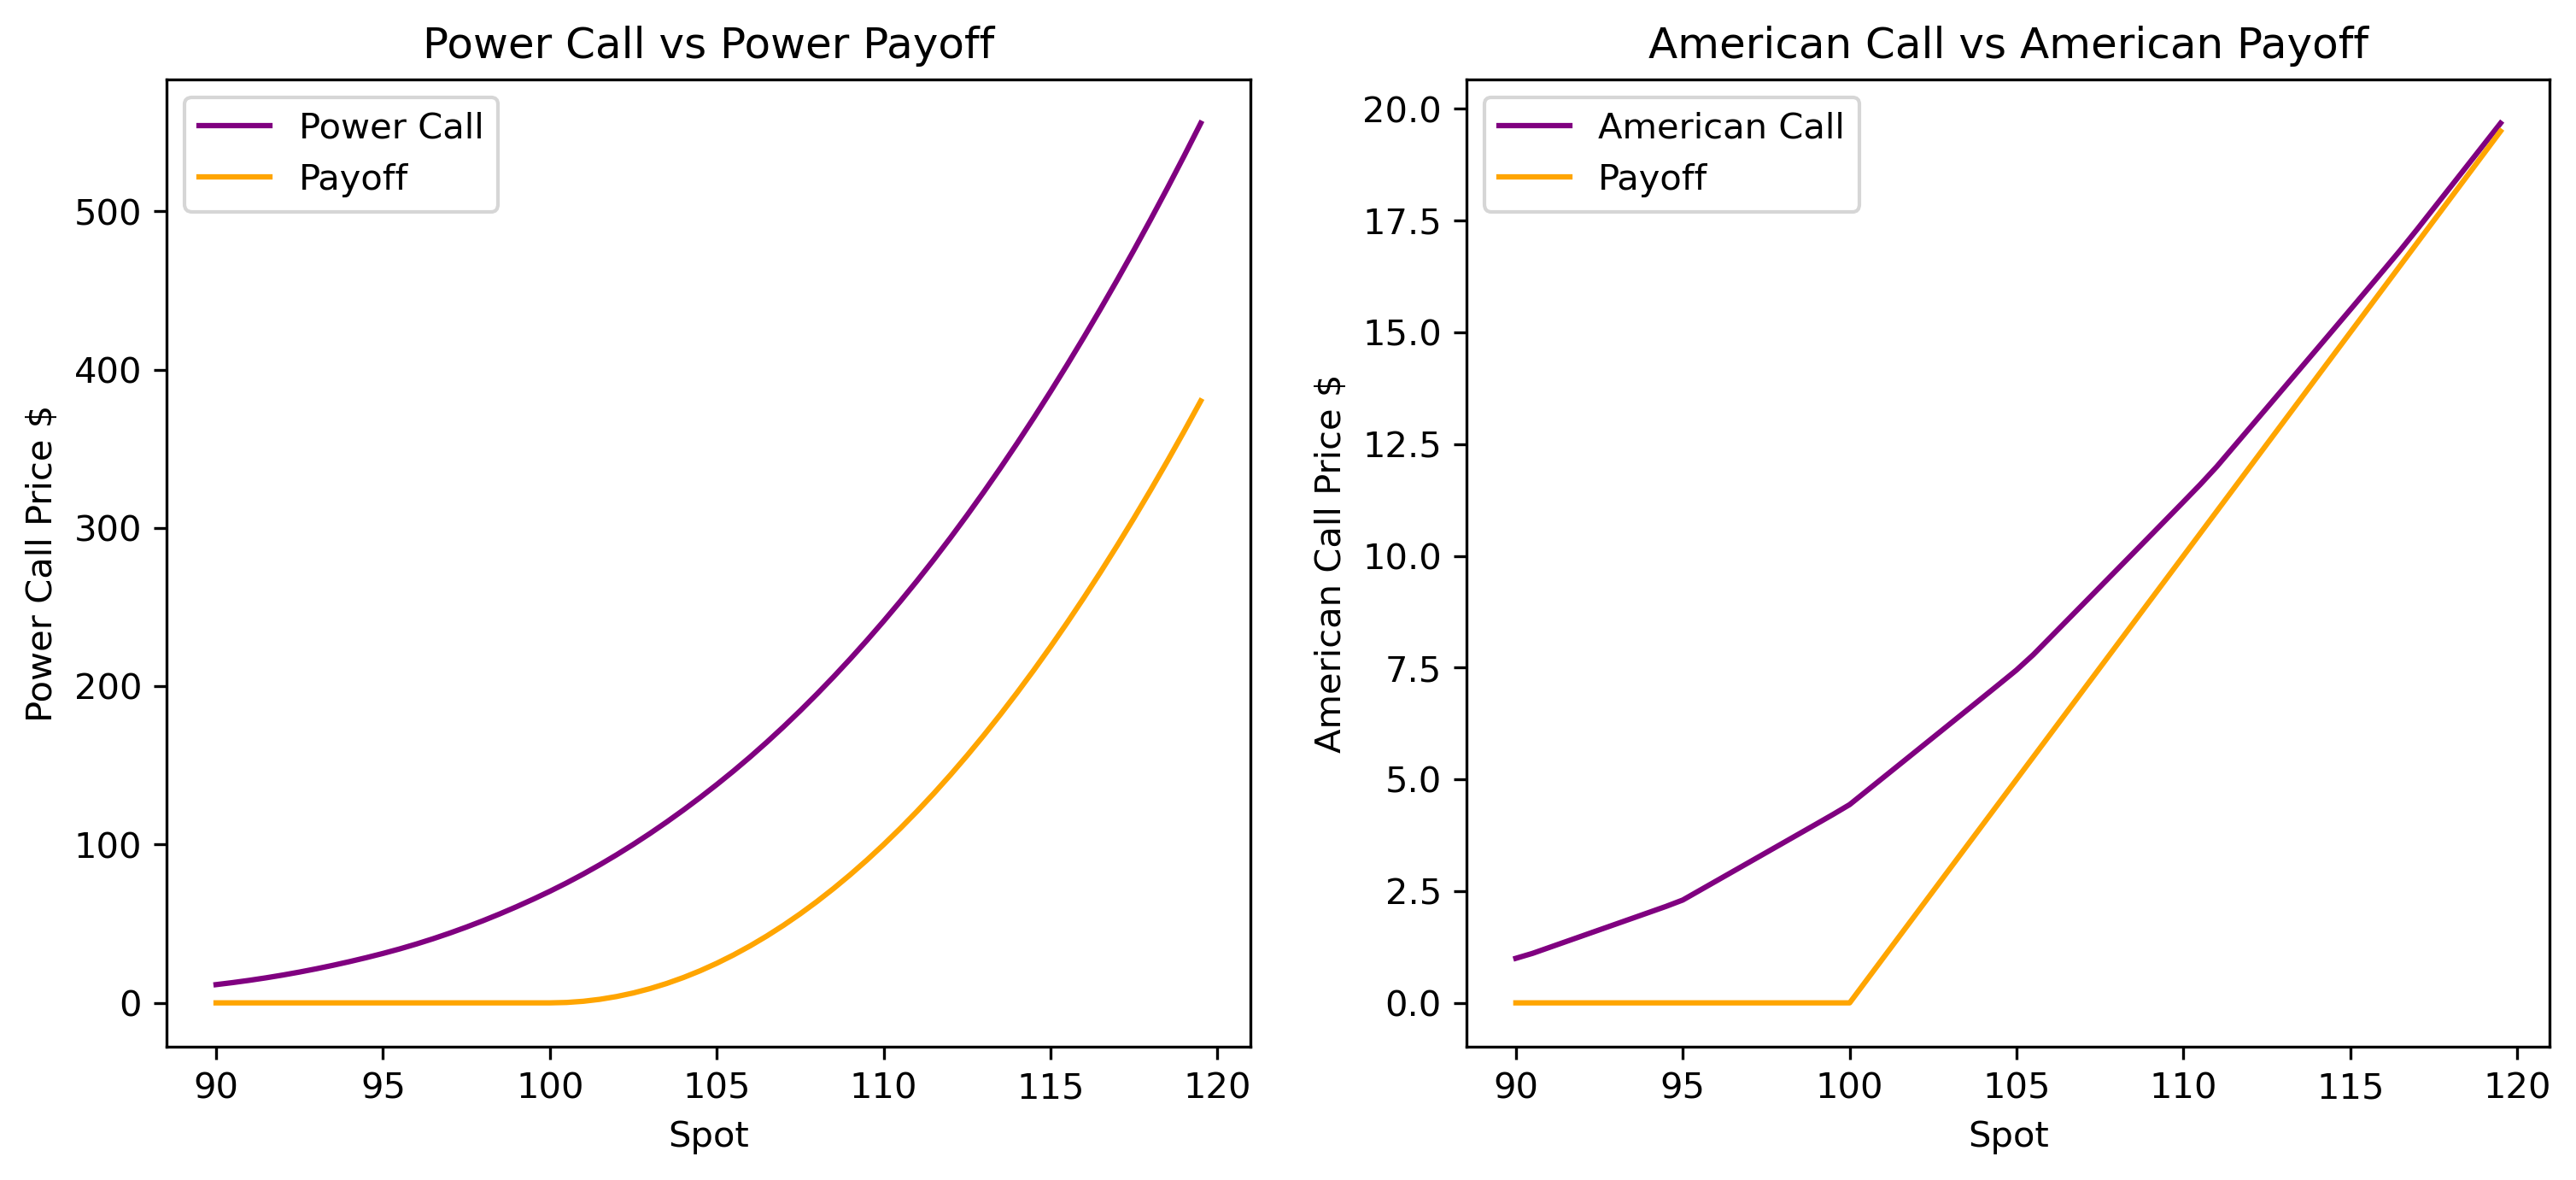

In [103]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(df4['Power Call'], label = 'Power Call', color = 'purple')
ax[0].plot(df4['Payoff'], label = 'Payoff', color = 'orange')
ax[0].set_title('Power Call vs Power Payoff')
ax[0].legend()
ax[0].set_xlabel("Spot")
ax[0].set_ylabel("Power Call Price $")

ax[1].plot(df5['American Call'], label = 'American Call', color = 'purple')
ax[1].plot(df5['Payoff'], label = 'Payoff', color = 'orange')
ax[1].set_title('American Call vs American Payoff')
ax[1].legend()
ax[1].set_xlabel("Spot")
ax[1].set_ylabel("American Call Price $")